# Inception V3 - DeepFake Detection


In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from tqdm import tqdm 
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

# DeepFake detection dataset

In [3]:
#training, validation, and test data

train_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\train"
valid_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\val"
test_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\test"

# Pre-processing steps

In [49]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(299),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(299),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(299),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

# Design & architecture

In [57]:
# Load pretrained Inception V3 Model

model = models.inception_v3(pretrained=True)

In [58]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

In [59]:
# Change the final layer of Inception V3 Model for Transfer Learning
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2), 
    nn.Sigmoid() # For using NLLLoss()
)

In [40]:
# Structure of model
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Define loss function with Adam optimizer

In [60]:
# Loss function and gradient descent
model.aux_logits = False
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.00001)

# Model training 

In [61]:
# Define training accuracy & loss 
train_accu = []
train_losses = []

# Function for defining the train
def train(epoch):
    
    print('\nEpoch : %d'%epoch)
    model.train()
 
    running_loss=0
    correct=0
    total=0
    CM=0
 
    for data in tqdm(train_loader):

        inputs,labels=data[0],data[1]
     
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()     
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        CM+=confusion_matrix(labels, predicted,labels=[0,1])
      
        tn=int(CM[0][0])
        tp=int(CM[1][1])
        fp=int(CM[0][1])
        fn=int(CM[1][0])
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    
    # Print performance metric values
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
    

In [62]:
# Define validation accuracy & loss

eval_losses=[]
eval_accu=[]
 
# Function for defining the validation
def validation(epoch):
    
    model.eval()
 
    running_loss=0
    correct=0
    total=0
    CM=0
 
    with torch.no_grad():
        for data in tqdm(validate_loader):
            
            images,labels=data[0],data[1]
            outputs=model(images)
 
            loss= loss_fn(outputs,labels)
            running_loss+=loss.item()
       
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            CM+=confusion_matrix(labels, predicted, labels=[0,1])
   
        tn=int(CM[0][0])
        tp=int(CM[1][1])
        fp=int(CM[0][1])
        fn=int(CM[1][0])
    validate_loss=running_loss/len(validate_loader)
    accu=100.*correct/total
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
 
    eval_losses.append(validate_loss)
    eval_accu.append(accu)
 
    # Print performance metric values
    print('Validate Loss: %.3f | Accuracy: %.3f'%(validate_loss,accu))
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
    

In [63]:
# Training the model for 15 epochs 

epochs=15
for epoch in range(1,epochs+1): 
    
    train(epoch)
    validation(epoch)

  0%|                                                                                          | 0/487 [00:00<?, ?it/s]


Epoch : 1


100%|██████████████████████████████████████████████████████████████████████████████| 487/487 [1:05:40<00:00,  8.09s/it]


Train Loss: 0.676 | Accuracy: 59.043
- Sensitivity :  99.10937330292168
- Specificity :  1.0223340673167662
- Precision:  59.18407056686989


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.669 | Accuracy: 59.156
- Sensitivity :  100.0
- Specificity :  0.0
- Precision:  59.15637860082305

Epoch : 2


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.668 | Accuracy: 59.158
- Sensitivity :  100.0
- Specificity :  0.015728216420257943
- Precision:  59.155744024672316


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.655 | Accuracy: 59.156
- Sensitivity :  100.0
- Specificity :  0.0
- Precision:  59.15637860082305

Epoch : 3


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.658 | Accuracy: 59.730
- Sensitivity :  99.78277397632236
- Specificity :  1.7301038062283738
- Precision:  59.52057013281503


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.642 | Accuracy: 59.208
- Sensitivity :  100.0
- Specificity :  0.12594458438287154
- Precision:  59.18682449819867

Epoch : 4


100%|██████████████████████████████████████████████████████████████████████████████| 487/487 [1:04:24<00:00,  7.94s/it]


Train Loss: 0.646 | Accuracy: 62.711
- Sensitivity :  98.41425002715324
- Specificity :  11.00975149418056
- Precision:  61.55988857938719


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.628 | Accuracy: 59.825
- Sensitivity :  99.91304347826086
- Specificity :  1.7632241813602016
- Precision:  59.56454121306376

Epoch : 5


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.635 | Accuracy: 65.936
- Sensitivity :  95.62289562289563
- Specificity :  22.94746775715634
- Precision:  64.24870466321244


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.611 | Accuracy: 63.323
- Sensitivity :  99.56521739130434
- Specificity :  10.831234256926953
- Precision:  61.79168915272532

Epoch : 6


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.626 | Accuracy: 68.224
- Sensitivity :  92.90757032692517
- Specificity :  32.47876690783265
- Precision:  66.58363820347162


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.598 | Accuracy: 67.027
- Sensitivity :  98.69565217391305
- Specificity :  21.158690176322416
- Precision:  64.45201590005678

Epoch : 7


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.618 | Accuracy: 69.072
- Sensitivity :  90.76789399370044
- Specificity :  37.65335011009752
- Precision:  67.82728674620566


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.591 | Accuracy: 67.695
- Sensitivity :  98.78260869565217
- Specificity :  22.670025188916874
- Precision:  64.91428571428571

Epoch : 8


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.611 | Accuracy: 70.112
- Sensitivity :  88.9431953948083
- Specificity :  42.84366152878263
- Precision:  69.2633003467817


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.573 | Accuracy: 71.708
- Sensitivity :  96.52173913043478
- Specificity :  35.768261964735515
- Precision:  68.51851851851852

Epoch : 9


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.606 | Accuracy: 70.633
- Sensitivity :  87.82448137286846
- Specificity :  45.737653350110094
- Precision:  70.09361997226074


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.568 | Accuracy: 72.531
- Sensitivity :  96.86956521739131
- Specificity :  37.27959697732997
- Precision:  69.10669975186104

Epoch : 10


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.600 | Accuracy: 71.050
- Sensitivity :  87.04246768762897
- Specificity :  47.89241899968544
- Precision:  70.75130219828728


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.555 | Accuracy: 75.154
- Sensitivity :  94.0
- Specificity :  47.858942065491185
- Precision:  72.3076923076923

Epoch : 11


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.596 | Accuracy: 71.802
- Sensitivity :  86.95557727815793
- Specificity :  49.85844605221768
- Precision:  71.52045738788637


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.562 | Accuracy: 72.994
- Sensitivity :  97.1304347826087
- Specificity :  38.0352644836272
- Precision:  69.42200124300808

Epoch : 12


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.589 | Accuracy: 72.605
- Sensitivity :  86.70576735092864
- Specificity :  52.18622208241585
- Precision:  72.42130091626599


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.550 | Accuracy: 75.103
- Sensitivity :  96.08695652173913
- Specificity :  44.7103274559194
- Precision:  71.56735751295336

Epoch : 13


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.588 | Accuracy: 72.284
- Sensitivity :  85.5436081242533
- Specificity :  53.08273041837056
- Precision:  72.52969886729902


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.547 | Accuracy: 75.154
- Sensitivity :  95.1304347826087
- Specificity :  46.221662468513856
- Precision:  71.92636423405654

Epoch : 14


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.585 | Accuracy: 72.554
- Sensitivity :  84.95709786032367
- Specificity :  54.59263919471532
- Precision:  73.04136707442338


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.540 | Accuracy: 76.286
- Sensitivity :  95.04347826086956
- Specificity :  49.1183879093199
- Precision:  73.01269205076821

Epoch : 15


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.581 | Accuracy: 73.196
- Sensitivity :  85.42413381123059
- Specificity :  55.489147530670024
- Precision:  73.53903693314633


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [04:37<00:00,  4.54s/it]


Validate Loss: 0.543 | Accuracy: 75.309
- Sensitivity :  95.91304347826087
- Specificity :  45.46599496221663
- Precision:  71.80989583333334


# Learning curves

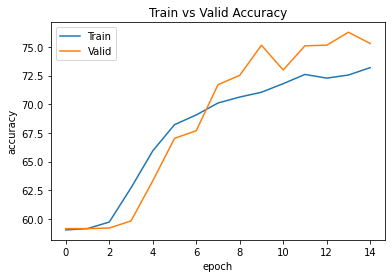

In [64]:
#training & validation accuracy plots

plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

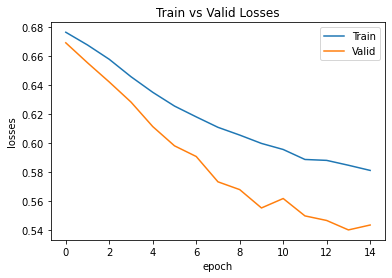

In [65]:
#training & validation loss plots

plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

# Testing model 

In [66]:
#Defining test function with test results

def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()

    with torch.no_grad():
    
        accuracy = 0
        CM=0
    
        for images, labels in iter(test_loader):
    
            output = model.forward(images)

            probabilities = torch.exp(output)
            preds = torch.argmax(output.data, 1)
            
            CM+=confusion_matrix(labels, preds, labels=[0,1])
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
            tn=CM[0][0]
            tp=CM[1][1]
            fp=CM[0][1]
            fn=CM[1][0]
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        f1_score=((2*sensitivity*precision)/(sensitivity+precision))
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))     
        print('Sensitivity : ',(tp/(tp+fn))*100)
        print('Specificity : ',(tn/(tn+fp))*100)
        print('Precision: ',(tp/(tp+fp))*100)
        print('Confusion Matrix', CM)
        print('F1-score', f1_score)

        
test_accuracy(model, test_loader)

Test Accuracy: 0.7607582211494446
Sensitivity :  94.70486111111111
Specificity :  48.99497487437186
Precision:  72.87909151636607
Confusion Matrix [[ 390  406]
 [  61 1091]]
F1-score 0.8237070592676482


# Saving the model

In [67]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "inceptionv3",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'DF_pytorch_model1_inceptionv3_15epochs_lr0.00001.pth ')
    
save_checkpoint(model)   